In [11]:
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import imageio
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [12]:
class ZeldaLevelDataset(Dataset):
    """Zelda Game levels dataset."""

    def __init__(self, data_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_dir = data_dir
        self.levels = self.load_levels()

    def __len__(self):
        return len(self.levels)

    def __getitem__(self, idx):
        return self.levels[idx]
    
    def load_levels(self):
        levels = []
        directory = os.fsencode(self.data_dir)
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.endswith(".pt"): 
                level = torch.load(self.data_dir + '/' + filename).float()
                levels.append(level)
        return levels
                
        

In [13]:
#transform = transforms.Compose([
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5,),(0.5,)),
#])
to_pil_image = transforms.ToPILImage()
train_data = ZeldaLevelDataset('./data/tensorizedConv/')
print("data size", len(train_data))

data size 1358


In [14]:
# learning parameters
no_cuda = False
batch_size = 16
epochs = 10000
sample_size = 64 # fixed sample size
nz = 8 # latent vector size
seed = 2020
temperature = 1.0
hard = False
categorical_dim = 10
k = 1 # number of steps to apply to the discriminator
is_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
torch.manual_seed(seed)
if is_cuda:
    torch.cuda.manual_seed(seed)

In [15]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [16]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)


In [17]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    if is_cuda:
        U = U.cuda()
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, hard=False):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    permuted_logits = logits.permute(0,2,3,1)
    permuted_y = gumbel_softmax_sample(permuted_logits, temperature)
    #if not hard:
    #    return y.view(-1, nz * categorical_dim)
    
    shape = permuted_y.size()
    _, ind = permuted_y.max(dim=-1)
    y_hard = torch.zeros_like(permuted_y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - permuted_y).detach() + permuted_y
    y_final = y_hard.permute(0,3,1,2)
    return y_final#.view(-1, latent_dim * categorical_dim)

In [18]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [19]:
# testing
print(iter(train_loader).next().shape)

torch.Size([16, 10, 16, 11])


In [65]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1760),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 16, 110)
    
class GeneratorConv(nn.Module):
    def __init__(self, nz, temp):
        super(GeneratorConv, self).__init__()
        self.nz = nz
        n_nodes = 64
        self.main = nn.Sequential(
            nn.Linear(nz, n_nodes),
            nn.ReLU(),
            Reshape(-1, 64, 1, 1),
            nn.ConvTranspose2d(64, 48, 3, 2, bias=False),
            #nn.BatchNorm2d(64),
            #nn.ReLU(True),
            
            nn.ReLU(),
            
            nn.ConvTranspose2d(48, 32, 3, 2, bias=False),
            
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 16, 3, 1, bias=False),
            
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 10, (8,3), 1, bias=False),
            #nn.BatchNorm2d(32),
            #nn.ReLU(True),
            #nn.LeakyReLU(0.2),
            
            #nn.ConvTranspose2d(32, 16, (2,2), 2, bias=False),
            #nn.BatchNorm2d(16),
            #nn.ReLU(True),
            #nn.LeakyReLU(0.2),
            
            #nn.ConvTranspose2d(16, 10, (2,1), 2, bias=False),
            nn.Tanh()
        )

    def forward(self, x, temp, hard, gumbel=True):
        x = self.main(x)
        #generated = F.softmax(x, dim=1)
        generated = x
        
        if gumbel:
            gumbeled = gumbel_softmax(x, temp, hard)
            return generated, gumbeled
        else:
            return generated, None

In [66]:
generator = GeneratorConv(nz, temperature).to(device)
#generator.apply(weights_init)
print(generator)

GeneratorConv(
  (main): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Reshape()
    (3): ConvTranspose2d(64, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): ReLU()
    (5): ConvTranspose2d(48, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (6): ReLU()
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (8): ReLU()
    (9): ConvTranspose2d(16, 10, kernel_size=(8, 3), stride=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [67]:
# CONV shape tests
test_level = torch.rand(1, 10, 16, 11)

#conv1 = nn.Conv2d(10, 16, 4, 1, bias=False)
#conv2 = nn.Conv2d(16, 32, 4, 1, bias=False)
#conv3 = nn.Conv2d(32, 48, 4, 1, bias=False)
#conv4 = nn.Conv2d(48, 64, (3,1), 1, bias=False)
#flatt = nn.Flatten()
#lin1 = nn.Linear(64*5*2, 128)

conv1 = nn.Conv2d(10, 16, (8,3), 2, bias=False)
conv2 = nn.Conv2d(16, 24, 3, 2, bias=False)
flatt = nn.Flatten()
lin1 = nn.Linear(96, 1)


print("dis")
x = conv1(test_level)
print(x.shape)
x = conv2(x)
print(x.shape)
#x = conv3(x)
#print(x.shape)
#x = conv4(x)
#print(x.shape)
x = flatt(x)
print(x.shape)
x = lin1(x)
print(x.shape)

print("gen")
test_latent = torch.rand(1, 8)
#deconv1 = nn.ConvTranspose2d(128, 64, (3,2), 1, bias=False)
#deconv2 = nn.ConvTranspose2d(64, 32, (2,2), 1, bias=False)
#deconv3 = nn.ConvTranspose2d(32, 16, (2,2), 2, bias=False)
#deconv4 = nn.ConvTranspose2d(16, 10, (2,1),2, bias=False)
#y = deconv1(test_latent)
lin1 = nn.Linear(8, 64)
reshape = Reshape(-1, 64, 1, 1)
deconv1 = nn.ConvTranspose2d(64, 48, 3, 2, bias=False)
deconv2 = nn.ConvTranspose2d(48, 32, 3, 2, bias=False)
deconv3 = nn.ConvTranspose2d(32, 16, 3, 1, bias=False)
deconv4 = nn.ConvTranspose2d(16, 10, (8,3), 1, bias=False)

y = lin1(test_latent)
print(y.shape)
y = reshape(y)
print(y.shape)
y = deconv1(y)
print(y.shape)
y = deconv2(y)
print(y.shape)
y = deconv3(y)
print(y.shape)
y = deconv4(y)
print(y.shape)
print(generator(test_latent, temperature, hard))


dis
torch.Size([1, 16, 5, 5])
torch.Size([1, 24, 2, 2])
torch.Size([1, 96])
torch.Size([1, 1])
gen
torch.Size([1, 64])
torch.Size([1, 64, 1, 1])
torch.Size([1, 48, 3, 3])
torch.Size([1, 32, 7, 7])
torch.Size([1, 16, 9, 9])
torch.Size([1, 10, 16, 11])
(tensor([[[[ 3.4716e-05, -3.0335e-04, -9.0325e-04,  ..., -1.5744e-04,
           -4.8568e-04, -1.9734e-04],
          [-1.4489e-04, -5.0174e-05, -1.8583e-03,  ..., -1.0805e-03,
           -3.8603e-04, -2.1813e-04],
          [-1.4239e-04, -1.3864e-04, -2.6922e-03,  ..., -1.0526e-03,
            2.0547e-04, -3.8571e-04],
          ...,
          [ 2.6437e-04, -4.2827e-04,  8.7226e-05,  ...,  6.1176e-04,
           -1.0446e-03,  1.4538e-04],
          [-7.0385e-04, -7.3322e-04, -3.2201e-04,  ..., -2.4074e-04,
           -6.7618e-04, -1.4151e-04],
          [-6.8166e-05,  7.1174e-05, -2.8401e-04,  ...,  1.6112e-04,
            1.3234e-04,  1.8125e-04]],

         [[ 2.0157e-04,  4.8046e-04,  1.5751e-04,  ..., -2.8293e-04,
           -8.7646e-

In [68]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 1760
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 1760)
        return self.main(x)

class DiscriminatorConv(nn.Module):
    def __init__(self):
        super(DiscriminatorConv, self).__init__()
        self.main = nn.Sequential(
            # input is B x C x H x W
            # B = 16, C = 10, H = 16, W = 11
            nn.Conv2d(10, 16, (8,3), 2, bias=False),
            # output:
            # B = 16, C = 32, H = (in+2P-k)/S + 1 = (16+0-4)/2 + 1 = 7, W = (in+2P-k)/S + 1 = (11+0-3)/2 + 1 = 5
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(16, 32, 3, 2, bias=False),
            # output:
            # B = 16, C = 32, H = (in+2P-k)/S + 1 = (7+0-3)/2 + 1 = 3, W = (in+2P-k)/S + 1 = (5+0-3)/2 + 1 = 2
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            #nn.Conv2d(32, 64, 4, 1, bias=False),
            # output:
            # B = 16, C = 1, H = (in+2P-k)/S + 1 = (10+0-4)/2 + 1 = 7, W = (in+2P-k)/S + 1 = (5+0-4)/2 + 1 = 2
            #nn.BatchNorm2d(64),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Conv2d(64, 128, (3,1), 1, bias=False),
            #nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(96, 1),
            #nn.ReLU(),
            #nn.Linear(256, 64),
            #nn.ReLU(),
            #nn.Linear(64, 16),
            #nn.ReLU(),
            #nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [69]:
discriminator = DiscriminatorConv().to(device)
#discriminator.apply(weights_init)
print(discriminator)

DiscriminatorConv(
  (main): Sequential(
    (0): Conv2d(10, 16, kernel_size=(8, 3), stride=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(16, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=96, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [70]:
temp_min = 0.5
ANNEAL_RATE = 0.00003
if is_cuda:
    generator.cuda()
    discriminator.cuda()

In [71]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [72]:
gan_criterion = nn.BCELoss()

In [73]:
from semantic_loss_pytorch import SemanticLoss
sl = SemanticLoss("constraints/basic_constraint.sdd", "constraints/basic_constraint.vtree")
#sl_constraints = []
#for i in range(10):
#    if i == 6:
#        continue
#    sl_constraints.append(SemanticLoss(f"constraints/final/constraint_{i}.sdd", f"constraints/final/constraint_{i}.vtree"))

#batch_size = 64
# constraints over a 2x2 variable
#xlevel = torch.rand((batch_size, 10, 16, 11))
#print(sl(probabilities=xlevel))
#xlevel = F.softmax(xlevel, dim=1)
#print(sl(probabilities=xlevel))
#for i in range(len(sl_constraints)):
#    x = xlevel[:, i, :, :]
#    #print(x[0])
#    loss = sl_constraints[i](probabilities=x)
#    print(loss)


In [74]:
#criterion = nn.BCEWithLogitsLoss()
#criterion = can_loss

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator
sats = []

# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

real_label = 1.
fake_label = 0.

# create the noise vector
noise = create_noise(64, nz)

In [75]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [76]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [77]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, temp, hard):
    optimizer.zero_grad()
    b_size = data_real.size(0)
    
    real_preds = discriminator(data_real)
    real_label = label_real(b_size)
    real_loss = gan_criterion(real_preds, real_label)
    real_score = torch.mean(real_preds).item()
    
    latent = create_noise(b_size, nz)
    fake_levels_probs, _ = generator(latent, temp, hard, gumbel=False)
    
    fake_preds = discriminator(fake_levels_probs)
    fake_label = label_fake(b_size)
    fake_loss = gan_criterion(fake_preds, fake_label)
    fake_score = torch.mean(fake_preds).item()
    
    loss = real_loss + fake_loss
    loss.backward()
    optimizer.step()
    
    return loss.item(), real_score, fake_score

In [78]:
def wall_var(fake_levels):
    b_size = fake_levels.shape[0]
    
    top_outer_wall = torch.prod(fake_levels[:, 8, 0, :].view(b_size, -1), dim=1)
    bottom_outer_wall = torch.prod(fake_levels[:, 8, 15, :].view(b_size, -1), dim=1)
    left_outer_wall = torch.prod(fake_levels[:, 8, 1:15, 0].view(b_size, -1), dim=1)
    right_outer_wall = torch.prod(fake_levels[:, 8, 1:15, 10].view(b_size, -1), dim=1)
    
    outer_walls = top_outer_wall * bottom_outer_wall * left_outer_wall * right_outer_wall
    return outer_walls.unsqueeze(1)
    
def semantic_loss(fake_levels):
    outer_walls = wall_var(fake_levels) + 1e-8
    #print(torch.sum(outer_walls))
    loss = sl(probabilities=outer_walls)
    return loss

rndtest = torch.rand(64, 10, 16, 11)
print(torch.sum(rndtest))
print(semantic_loss(torch.rand(64, 10, 16, 11)))

tensor(56335.2734)
tensor(18.4207)


In [79]:
# function to train the generator network
def train_generator(optimizer, temp, hard, b_size):
    optimizer.zero_grad()
    
    latent = create_noise(b_size, nz)
    fake_levels_probs, _ = generator(latent, temp, hard, gumbel=False)
    
    preds = discriminator(fake_levels_probs)
    label = label_real(b_size)
    adversarial_loss = gan_criterion(preds, label)
    #constraint_loss = can_loss(fake_levels)
    
    #loss = adversarial_loss + constraint_loss
    #selected = fake_levels[:, 8, 0, :].unsqueeze(2)
    #opposite = 1 - selected
    #third_tensor = torch.cat((selected, opposite), 2)
    
    #loss = torch.tensor(0.0)
    #with io.capture_output() as captured:
    #    for i in range(third_tensor.shape[0]):
    #        third_tensor_one = third_tensor[i]
#
    #        loss += circuit_cons(third_tensor_one)
    #loss /= b_size
    constraint_loss = 0.0
    
    #for i in range(len(sl_constraints)):
    #    x = fake_levels_probs[:, i, :, :]
    #    constraint_loss += sl_constraints[i](probabilities=x)
        
    #x = fake_levels_probs[:, 8, :, :]
    #constraint_loss = sl(probabilities=fake_levels_probs)
    #print(torch.sum(fake_levels_probs))
    constraint_loss = semantic_loss(fake_levels_probs)
    #print(constraint_loss)
    
    loss = adversarial_loss + constraint_loss
    
    loss.backward()
    optimizer.step()
    
    #loss_constraint = can_loss(data_fake)
    #loss_constraint.backward()
    
    return loss.item(), constraint_loss.item()

In [80]:
def transform_to_image_format(level):
    colorR = torch.tensor([0.69,0.3, 0.8,0,   0.06,0.08,0.52,0.3, 0.26,0])
    colorG = torch.tensor([0.69,1,   0,  0.14,0.12,0.94,0.13,0.52,0.14,0])
    colorB = torch.tensor([0.69,1,   0.1,0.8 ,0.35,0.33,0.08,0.08,0.31,0])
    
    colorMap = torch.tensor([[0.69,0.3, 0.8,0,   0.06,0.08,0.52,0.3, 0.26,0],
                            [0.69,1,   0,  0.14,0.12,0.94,0.13,0.52,0.14,0],
                            [0.69,1,   0.1,0.8 ,0.35,0.33,0.08,0.08,0.31,0]]).transpose(0,1)
    permuted_level = level.permute(0,2,3,1)
    
    colored_permuted_level = torch.matmul(permuted_level,colorMap)
    colored_level = colored_permuted_level.permute(0,3,1,2)
    
    return colored_level

In [81]:
generator.train()
discriminator.train()

DiscriminatorConv(
  (main): Sequential(
    (0): Conv2d(10, 16, kernel_size=(8, 3), stride=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(16, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=96, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [85]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    sat = 0.0
    temp = temperature
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        level = data
        level = level.to(device)
        b_size = len(level)
        
        # train the discriminator network
        loss_d_cur, real_score, fake_score = train_discriminator(optim_d, level, temp, hard)
        loss_d += loss_d_cur
        
        # train the generator network
        for _ in range(1):
            loss_g_cur, sat_cur = train_generator(optim_g, temp, hard, b_size)
        loss_g += loss_g_cur
        sat += sat_cur
        
        if bi % 100 == 1:
            temp = np.maximum(temp * np.exp(-ANNEAL_RATE * bi), temp_min)
        
    # create the final fake image for the epoch
    generated_level_probs, generated_level = generator(noise, temp, hard, gumbel=True)
    generated_level = generated_level.cpu().detach()
    # make the images as grid
    #generated_level = transform_to_image_format(generated_level)
    #generated_level = make_grid(generated_level)
    # save the generated torch tensor models to disk
    #save_generator_image(generated_level, f"./outputs/gen_img{epoch}.png")
    images.append(generated_level)
    epoch_loss_g = loss_g / (bi+1) # total generator loss for the epoch
    epoch_loss_d = loss_d / (bi+1) # total discriminator loss for the epoch
    epoch_sat = sat / (bi+1)
    if epoch == 0 or (epoch_loss_g < losses_g[-1] and epoch_loss_d > losses_d[-1]):
        torch.save(generator.state_dict(), f'./outputs/generators/5_19/generator_tanh_relu.pth')
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    #epoch_sat = satisfaction(generated_level)
    sats.append(epoch_sat)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g}, Discriminator loss: {epoch_loss_d}, Satisfaction: {epoch_sat}")
    

85it [00:01, 44.75it/s]                                                                                                                                     


Epoch 0 of 10000
Generator loss: 1.649085539930007, Discriminator loss: 0.7075278198017794, Satisfaction: 0.033164760733351985


85it [00:01, 56.08it/s]                                                                                                                                     


Epoch 1 of 10000
Generator loss: 1.8657701772802016, Discriminator loss: 0.6857230582657983, Satisfaction: 0.04809921572313589


85it [00:01, 56.69it/s]                                                                                                                                     


Epoch 2 of 10000
Generator loss: 1.850208994921516, Discriminator loss: 0.692818350651685, Satisfaction: 0.049909269678242066


85it [00:01, 55.96it/s]                                                                                                                                     


Epoch 3 of 10000
Generator loss: 2.0068671394796933, Discriminator loss: 0.4882182829520282, Satisfaction: 0.03576731055098421


85it [00:01, 56.66it/s]                                                                                                                                     


Epoch 4 of 10000
Generator loss: 2.1873453056111054, Discriminator loss: 0.48048133254051206, Satisfaction: 0.023992359747781473


85it [00:01, 57.02it/s]                                                                                                                                     


Epoch 5 of 10000
Generator loss: 2.362270645534291, Discriminator loss: 0.46170027238481187, Satisfaction: 0.013062473342699162


85it [00:01, 57.52it/s]                                                                                                                                     


Epoch 6 of 10000
Generator loss: 2.606859435754664, Discriminator loss: 0.3150949032867656, Satisfaction: 0.0060239950688008


85it [00:01, 55.08it/s]                                                                                                                                     


Epoch 7 of 10000
Generator loss: 2.7846992632922003, Discriminator loss: 0.24477387701763825, Satisfaction: 0.0033647519618491915


85it [00:01, 55.44it/s]                                                                                                                                     


Epoch 8 of 10000
Generator loss: 2.6864367232603183, Discriminator loss: 0.2815719006692662, Satisfaction: 0.01025484731859144


85it [00:01, 42.55it/s]                                                                                                                                     


Epoch 9 of 10000
Generator loss: 2.7736270119162167, Discriminator loss: 0.2992346709265428, Satisfaction: 0.030622663568047916


85it [00:01, 51.17it/s]                                                                                                                                     


Epoch 10 of 10000
Generator loss: 2.858991760366103, Discriminator loss: 0.2453213968697716, Satisfaction: 0.04727082011454246


85it [00:01, 57.11it/s]                                                                                                                                     


Epoch 11 of 10000
Generator loss: 3.11988286411061, Discriminator loss: 0.20614130295374813, Satisfaction: 0.03425136210725588


85it [00:01, 56.20it/s]                                                                                                                                     


Epoch 12 of 10000
Generator loss: 3.2573589044458724, Discriminator loss: 0.1786130594856599, Satisfaction: 0.0239974224830375


85it [00:01, 57.35it/s]                                                                                                                                     


Epoch 13 of 10000
Generator loss: 3.922748590918148, Discriminator loss: 0.12466842378763592, Satisfaction: 0.010569099101292737


85it [00:01, 57.49it/s]                                                                                                                                     


Epoch 14 of 10000
Generator loss: 3.8819143856272977, Discriminator loss: 0.09667293779990252, Satisfaction: 0.0040216109249740836


85it [00:01, 56.75it/s]                                                                                                                                     


Epoch 15 of 10000
Generator loss: 3.4682203741634594, Discriminator loss: 0.12723625319845536, Satisfaction: 0.001723169141640777


85it [00:01, 51.31it/s]                                                                                                                                     


Epoch 16 of 10000
Generator loss: 3.60428827790653, Discriminator loss: 0.11441662955810042, Satisfaction: 0.0014452953576384222


85it [00:01, 54.96it/s]                                                                                                                                     


Epoch 17 of 10000
Generator loss: 3.8088728483985452, Discriminator loss: 0.09543462237891029, Satisfaction: 0.0019328883054721005


85it [00:01, 57.30it/s]                                                                                                                                     


Epoch 18 of 10000
Generator loss: 4.072983486512128, Discriminator loss: 0.0783078517545672, Satisfaction: 0.0014068260946420623


85it [00:01, 56.95it/s]                                                                                                                                     


Epoch 19 of 10000
Generator loss: 4.200006395227769, Discriminator loss: 0.07174088560483034, Satisfaction: 0.000668845434248557


85it [00:01, 54.94it/s]                                                                                                                                     


Epoch 20 of 10000
Generator loss: 4.087532509074491, Discriminator loss: 0.08004516380674699, Satisfaction: 0.000283463134752203


85it [00:01, 52.94it/s]                                                                                                                                     


Epoch 21 of 10000
Generator loss: 4.327629810221055, Discriminator loss: 0.06815885049017037, Satisfaction: 0.00014566525762133738


85it [00:01, 53.74it/s]                                                                                                                                     


Epoch 22 of 10000
Generator loss: 4.505037927627564, Discriminator loss: 0.062498677521944046, Satisfaction: 0.0002851381433977033


85it [00:01, 53.90it/s]                                                                                                                                     


Epoch 23 of 10000
Generator loss: 4.208565150990205, Discriminator loss: 0.06858824953875121, Satisfaction: 0.00027459113968207556


85it [00:01, 46.62it/s]                                                                                                                                     


Epoch 24 of 10000
Generator loss: 4.568499032188864, Discriminator loss: 0.06817012321861352, Satisfaction: 0.0006034625774619224


85it [00:01, 44.49it/s]                                                                                                                                     


Epoch 25 of 10000
Generator loss: 4.5544070776771095, Discriminator loss: 0.06194438077509403, Satisfaction: 0.001310487073051798


85it [00:02, 35.43it/s]                                                                                                                                     


Epoch 26 of 10000
Generator loss: 4.451209514281329, Discriminator loss: 0.06264256330973962, Satisfaction: 0.0002730526904034538


85it [00:02, 42.38it/s]                                                                                                                                     


Epoch 27 of 10000
Generator loss: 4.812294146593879, Discriminator loss: 0.04350071295219309, Satisfaction: 8.117237628218444e-05


85it [00:01, 57.06it/s]                                                                                                                                     


Epoch 28 of 10000
Generator loss: 4.7790210555581485, Discriminator loss: 0.04541609497631297, Satisfaction: 0.00013955497901513487


85it [00:01, 55.88it/s]                                                                                                                                     


Epoch 29 of 10000
Generator loss: 4.868859234978171, Discriminator loss: 0.04469771811409908, Satisfaction: 0.000783465982428478


85it [00:01, 56.46it/s]                                                                                                                                     


Epoch 30 of 10000
Generator loss: 5.262471053179572, Discriminator loss: 0.033086693341679435, Satisfaction: 0.00019240258019742802


85it [00:01, 55.49it/s]                                                                                                                                     


Epoch 31 of 10000
Generator loss: 5.572409573723288, Discriminator loss: 0.026585088385378614, Satisfaction: 1.3235837115430246e-05


85it [00:01, 56.38it/s]                                                                                                                                     


Epoch 32 of 10000
Generator loss: 5.878742700464585, Discriminator loss: 0.021971759638365576, Satisfaction: 2.187844785339621e-06


85it [00:01, 56.71it/s]                                                                                                                                     


Epoch 33 of 10000
Generator loss: 5.6549011847552135, Discriminator loss: 0.02305908749866135, Satisfaction: 1.753077871104752e-08


85it [00:01, 55.78it/s]                                                                                                                                     


Epoch 34 of 10000
Generator loss: 5.95348663891063, Discriminator loss: 0.018391416210900336, Satisfaction: 0.0


85it [00:01, 56.58it/s]                                                                                                                                     


Epoch 35 of 10000
Generator loss: 6.319185486961813, Discriminator loss: 0.015700449224780588, Satisfaction: 0.0


85it [00:01, 55.97it/s]                                                                                                                                     


Epoch 36 of 10000
Generator loss: 6.291677716199089, Discriminator loss: 0.016434704791754483, Satisfaction: 0.0


85it [00:01, 55.69it/s]                                                                                                                                     


Epoch 37 of 10000
Generator loss: 6.389656942030963, Discriminator loss: 0.01550533756175462, Satisfaction: 0.0


85it [00:01, 56.34it/s]                                                                                                                                     


Epoch 38 of 10000
Generator loss: 6.6304995985592114, Discriminator loss: 0.018784298632732208, Satisfaction: 0.0


85it [00:01, 56.09it/s]                                                                                                                                     


Epoch 39 of 10000
Generator loss: 7.044386521507712, Discriminator loss: 0.008496676182703061, Satisfaction: 0.0


85it [00:01, 56.33it/s]                                                                                                                                     


Epoch 40 of 10000
Generator loss: 7.238965982549331, Discriminator loss: 0.00756546898799784, Satisfaction: 0.0


85it [00:01, 56.72it/s]                                                                                                                                     


Epoch 41 of 10000
Generator loss: 7.4149151914259965, Discriminator loss: 0.006700957558282158, Satisfaction: 0.0


85it [00:01, 55.05it/s]                                                                                                                                     


Epoch 42 of 10000
Generator loss: 7.663153104221119, Discriminator loss: 0.005700923357268467, Satisfaction: 0.0


85it [00:02, 37.66it/s]                                                                                                                                     


Epoch 43 of 10000
Generator loss: 7.601096153259277, Discriminator loss: 0.005229345489950741, Satisfaction: 0.0


85it [00:01, 55.78it/s]                                                                                                                                     


Epoch 44 of 10000
Generator loss: 7.898558100532083, Discriminator loss: 0.004723189672564759, Satisfaction: 0.0


85it [00:01, 55.06it/s]                                                                                                                                     


Epoch 45 of 10000
Generator loss: 8.127324093089385, Discriminator loss: 0.004130152651273152, Satisfaction: 0.0


85it [00:01, 53.08it/s]                                                                                                                                     


Epoch 46 of 10000
Generator loss: 7.744885624156279, Discriminator loss: 0.004279611732208115, Satisfaction: 0.0


85it [00:01, 55.56it/s]                                                                                                                                     


Epoch 47 of 10000
Generator loss: 8.165305210562313, Discriminator loss: 0.0037463838631725485, Satisfaction: 0.0


85it [00:01, 56.06it/s]                                                                                                                                     


Epoch 48 of 10000
Generator loss: 8.29393061469583, Discriminator loss: 0.003883400232092861, Satisfaction: 0.0


85it [00:01, 56.06it/s]                                                                                                                                     


Epoch 49 of 10000
Generator loss: 8.786293343936697, Discriminator loss: 0.002746226079761982, Satisfaction: 0.0


85it [00:01, 55.98it/s]                                                                                                                                     


Epoch 50 of 10000
Generator loss: 9.007363397934858, Discriminator loss: 0.0023053810527712544, Satisfaction: 0.0


85it [00:01, 56.93it/s]                                                                                                                                     


Epoch 51 of 10000
Generator loss: 9.064465836917654, Discriminator loss: 0.002039857951732462, Satisfaction: 0.0


85it [00:01, 54.82it/s]                                                                                                                                     


Epoch 52 of 10000
Generator loss: 8.892666311825023, Discriminator loss: 0.003050617952420212, Satisfaction: 0.0


85it [00:01, 55.32it/s]                                                                                                                                     


Epoch 53 of 10000
Generator loss: 9.473337863473331, Discriminator loss: 0.0017626477884786094, Satisfaction: 0.0


85it [00:01, 42.66it/s]                                                                                                                                     


Epoch 54 of 10000
Generator loss: 9.91906552034266, Discriminator loss: 0.0015190310906344916, Satisfaction: 0.0


85it [00:02, 31.52it/s]                                                                                                                                     


Epoch 55 of 10000
Generator loss: 9.904696554296157, Discriminator loss: 0.001345561392030076, Satisfaction: 0.0


85it [00:01, 51.80it/s]                                                                                                                                     


Epoch 56 of 10000
Generator loss: 9.852591851178337, Discriminator loss: 0.0014420269803582307, Satisfaction: 0.0


85it [00:01, 43.90it/s]                                                                                                                                     


Epoch 57 of 10000
Generator loss: 9.291396051294663, Discriminator loss: 0.00173708652420079, Satisfaction: 0.0


85it [00:01, 55.86it/s]                                                                                                                                     


Epoch 58 of 10000
Generator loss: 9.520277718936695, Discriminator loss: 0.001451746335335295, Satisfaction: 0.0


85it [00:01, 49.59it/s]                                                                                                                                     


Epoch 59 of 10000
Generator loss: 9.419027373370003, Discriminator loss: 0.0015095389680936933, Satisfaction: 0.0


85it [00:01, 52.09it/s]                                                                                                                                     


Epoch 60 of 10000
Generator loss: 9.752564228282255, Discriminator loss: 0.0013575911946485148, Satisfaction: 0.0


85it [00:01, 51.54it/s]                                                                                                                                     


Epoch 61 of 10000
Generator loss: 9.527690203049604, Discriminator loss: 0.0013014421969487825, Satisfaction: 0.0


85it [00:01, 48.13it/s]                                                                                                                                     


Epoch 62 of 10000
Generator loss: 9.629101080052992, Discriminator loss: 0.0013182388529564967, Satisfaction: 0.0


85it [00:01, 52.15it/s]                                                                                                                                     


Epoch 63 of 10000
Generator loss: 9.97443811753217, Discriminator loss: 0.0010518749549245352, Satisfaction: 0.0


85it [00:01, 48.89it/s]                                                                                                                                     


Epoch 64 of 10000
Generator loss: 10.37861753351548, Discriminator loss: 0.0011877321922357249, Satisfaction: 0.0


85it [00:01, 50.89it/s]                                                                                                                                     


Epoch 65 of 10000
Generator loss: 10.10821953941794, Discriminator loss: 0.0009311360882266479, Satisfaction: 0.0


85it [00:01, 52.30it/s]                                                                                                                                     


Epoch 66 of 10000
Generator loss: 9.900132740245146, Discriminator loss: 0.0010694983240682632, Satisfaction: 0.0


85it [00:01, 54.00it/s]                                                                                                                                     


Epoch 67 of 10000
Generator loss: 10.23649803610409, Discriminator loss: 0.0008462865830070394, Satisfaction: 0.0


85it [00:01, 52.70it/s]                                                                                                                                     


Epoch 68 of 10000
Generator loss: 10.323429522794836, Discriminator loss: 0.0007539901221581899, Satisfaction: 0.0


85it [00:01, 52.98it/s]                                                                                                                                     


Epoch 69 of 10000
Generator loss: 10.608493771272547, Discriminator loss: 0.0007520490010981174, Satisfaction: 0.0


85it [00:01, 56.57it/s]                                                                                                                                     


Epoch 70 of 10000
Generator loss: 10.707558205548455, Discriminator loss: 0.0007553629780886695, Satisfaction: 0.0


85it [00:01, 57.67it/s]                                                                                                                                     


Epoch 71 of 10000
Generator loss: 10.754051298253676, Discriminator loss: 0.0006592959394979784, Satisfaction: 0.0


85it [00:01, 57.59it/s]                                                                                                                                     


Epoch 72 of 10000
Generator loss: 10.351687913782456, Discriminator loss: 0.0007691718932405552, Satisfaction: 0.0


85it [00:01, 55.90it/s]                                                                                                                                     


Epoch 73 of 10000
Generator loss: 10.781746606265797, Discriminator loss: 0.0006514344824929995, Satisfaction: 0.0


85it [00:01, 52.14it/s]                                                                                                                                     


Epoch 74 of 10000
Generator loss: 11.13927521425135, Discriminator loss: 0.0005274950644782032, Satisfaction: 0.0


85it [00:01, 57.37it/s]                                                                                                                                     


Epoch 75 of 10000
Generator loss: 10.40795436185949, Discriminator loss: 0.0006951966245918918, Satisfaction: 0.0


85it [00:01, 48.85it/s]                                                                                                                                     


Epoch 76 of 10000
Generator loss: 10.198522006764131, Discriminator loss: 0.0006506531663677272, Satisfaction: 0.0


85it [00:01, 52.10it/s]                                                                                                                                     


Epoch 77 of 10000
Generator loss: 10.772760739045985, Discriminator loss: 0.0005491369963719454, Satisfaction: 0.0


85it [00:02, 42.05it/s]                                                                                                                                     


Epoch 78 of 10000
Generator loss: 10.717293997371899, Discriminator loss: 0.0005770593419369748, Satisfaction: 0.0


85it [00:01, 44.56it/s]                                                                                                                                     


Epoch 79 of 10000
Generator loss: 11.093663484909955, Discriminator loss: 0.00047731234645813375, Satisfaction: 0.0


85it [00:01, 47.39it/s]                                                                                                                                     


Epoch 80 of 10000
Generator loss: 10.927613897884592, Discriminator loss: 0.0004575783739496461, Satisfaction: 0.0


85it [00:01, 49.46it/s]                                                                                                                                     


Epoch 81 of 10000
Generator loss: 10.936354839100558, Discriminator loss: 0.0004764911255573251, Satisfaction: 0.0


85it [00:01, 58.06it/s]                                                                                                                                     


Epoch 82 of 10000
Generator loss: 11.407741535411162, Discriminator loss: 0.0003663026765399777, Satisfaction: 0.0


85it [00:01, 44.28it/s]                                                                                                                                     


Epoch 83 of 10000
Generator loss: 11.765396892323214, Discriminator loss: 0.0003370667826589745, Satisfaction: 0.0


85it [00:01, 44.37it/s]                                                                                                                                     


Epoch 84 of 10000
Generator loss: 11.926300463956945, Discriminator loss: 0.0003838391139973229, Satisfaction: 0.0


85it [00:02, 37.56it/s]                                                                                                                                     


Epoch 85 of 10000
Generator loss: 12.076744988385368, Discriminator loss: 0.000271078321041868, Satisfaction: 0.0


85it [00:02, 40.88it/s]                                                                                                                                     


Epoch 86 of 10000
Generator loss: 12.415533065795898, Discriminator loss: 0.000268332202840076, Satisfaction: 0.0


85it [00:02, 39.61it/s]                                                                                                                                     


Epoch 87 of 10000
Generator loss: 12.228239115546732, Discriminator loss: 0.0002741100019193254, Satisfaction: 0.0


85it [00:01, 52.40it/s]                                                                                                                                     


Epoch 88 of 10000
Generator loss: 11.949268341064453, Discriminator loss: 0.00026252850794288165, Satisfaction: 0.0


85it [00:01, 55.04it/s]                                                                                                                                     


Epoch 89 of 10000
Generator loss: 12.058751532610724, Discriminator loss: 0.0002771470567334772, Satisfaction: 0.0


85it [00:01, 46.67it/s]                                                                                                                                     


Epoch 90 of 10000
Generator loss: 11.866740350162281, Discriminator loss: 0.0002823534732348943, Satisfaction: 0.0


85it [00:01, 44.23it/s]                                                                                                                                     


Epoch 91 of 10000
Generator loss: 10.517792724160588, Discriminator loss: 0.0005149125572643243, Satisfaction: 0.0


85it [00:01, 50.39it/s]                                                                                                                                     


Epoch 92 of 10000
Generator loss: 11.545110915688907, Discriminator loss: 0.0002784011219559676, Satisfaction: 0.0


85it [00:02, 38.12it/s]                                                                                                                                     


Epoch 93 of 10000
Generator loss: 11.991331279979033, Discriminator loss: 0.00024073733169215677, Satisfaction: 0.0


85it [00:02, 32.08it/s]                                                                                                                                     


Epoch 94 of 10000
Generator loss: 12.295971163581399, Discriminator loss: 0.000220023601757609, Satisfaction: 0.0


85it [00:01, 55.16it/s]                                                                                                                                     


Epoch 95 of 10000
Generator loss: 12.476207340464873, Discriminator loss: 0.00019155881283736294, Satisfaction: 0.0


85it [00:01, 58.80it/s]                                                                                                                                     


Epoch 96 of 10000
Generator loss: 12.630015047858743, Discriminator loss: 0.00018006070501595627, Satisfaction: 0.0


85it [00:01, 59.20it/s]                                                                                                                                     


Epoch 97 of 10000
Generator loss: 12.754463588490205, Discriminator loss: 0.0001636746917724582, Satisfaction: 0.0


85it [00:01, 58.64it/s]                                                                                                                                     


Epoch 98 of 10000
Generator loss: 12.953701613931095, Discriminator loss: 0.00016868707928498384, Satisfaction: 0.0


85it [00:01, 57.57it/s]                                                                                                                                     


Epoch 99 of 10000
Generator loss: 13.355810513215907, Discriminator loss: 0.000168685558353044, Satisfaction: 0.0


85it [00:01, 58.99it/s]                                                                                                                                     


Epoch 100 of 10000
Generator loss: 13.533505765129538, Discriminator loss: 0.00013289493722635706, Satisfaction: 0.0


85it [00:01, 57.05it/s]                                                                                                                                     


Epoch 101 of 10000
Generator loss: 13.621587293288288, Discriminator loss: 0.00012961105470929074, Satisfaction: 0.0


85it [00:01, 59.10it/s]                                                                                                                                     


Epoch 102 of 10000
Generator loss: 13.625782360750087, Discriminator loss: 0.00012491677463164223, Satisfaction: 0.0


85it [00:01, 59.10it/s]                                                                                                                                     


Epoch 103 of 10000
Generator loss: 13.289200524722828, Discriminator loss: 0.00011695350878974696, Satisfaction: 0.0


85it [00:01, 59.35it/s]                                                                                                                                     


Epoch 104 of 10000
Generator loss: 12.664454303068274, Discriminator loss: 0.00015556332248653395, Satisfaction: 0.0


85it [00:01, 55.96it/s]                                                                                                                                     


Epoch 105 of 10000
Generator loss: 10.475465976490694, Discriminator loss: 0.0004660671908127637, Satisfaction: 0.0


85it [00:01, 54.05it/s]                                                                                                                                     


Epoch 106 of 10000
Generator loss: 11.005482999016257, Discriminator loss: 0.00042400619645109947, Satisfaction: 0.0


85it [00:01, 48.08it/s]                                                                                                                                     


Epoch 107 of 10000
Generator loss: 10.630089793485753, Discriminator loss: 0.00031113007237710166, Satisfaction: 0.0


85it [00:01, 57.34it/s]                                                                                                                                     


Epoch 108 of 10000
Generator loss: 11.790193815792309, Discriminator loss: 0.00023494463205091, Satisfaction: 0.0


85it [00:01, 57.63it/s]                                                                                                                                     


Epoch 109 of 10000
Generator loss: 12.051277934803682, Discriminator loss: 0.00015741143189884228, Satisfaction: 0.0


85it [00:01, 58.68it/s]                                                                                                                                     


Epoch 110 of 10000
Generator loss: 11.398238922567929, Discriminator loss: 0.00020442080747349846, Satisfaction: 0.0


85it [00:01, 58.68it/s]                                                                                                                                     


Epoch 111 of 10000
Generator loss: 12.06585677651798, Discriminator loss: 0.00013662665737416212, Satisfaction: 0.0


85it [00:01, 58.41it/s]                                                                                                                                     


Epoch 112 of 10000
Generator loss: 11.52977918737075, Discriminator loss: 0.00017318163441172254, Satisfaction: 0.0


85it [00:01, 57.30it/s]                                                                                                                                     


Epoch 113 of 10000
Generator loss: 12.533824628942153, Discriminator loss: 0.00015237599834697047, Satisfaction: 0.0


85it [00:01, 53.48it/s]                                                                                                                                     


Epoch 114 of 10000
Generator loss: 13.26683588588939, Discriminator loss: 8.717936250511283e-05, Satisfaction: 0.0


85it [00:02, 41.63it/s]                                                                                                                                     


Epoch 115 of 10000
Generator loss: 13.450155931360582, Discriminator loss: 8.487642722577542e-05, Satisfaction: 0.0


85it [00:01, 54.79it/s]                                                                                                                                     


Epoch 116 of 10000
Generator loss: 12.050214161592372, Discriminator loss: 0.00011634698423543287, Satisfaction: 0.0


85it [00:01, 58.28it/s]                                                                                                                                     


Epoch 117 of 10000
Generator loss: 11.567911495881923, Discriminator loss: 0.0003146525418046889, Satisfaction: 0.0


85it [00:02, 41.98it/s]                                                                                                                                     


Epoch 118 of 10000
Generator loss: 12.207491280050839, Discriminator loss: 0.0001563620544723509, Satisfaction: 0.0


85it [00:02, 36.42it/s]                                                                                                                                     


Epoch 119 of 10000
Generator loss: 12.570366971633014, Discriminator loss: 0.00011348656095352078, Satisfaction: 0.0


85it [00:02, 39.63it/s]                                                                                                                                     


Epoch 120 of 10000
Generator loss: 12.883189751120174, Discriminator loss: 0.00010760883644038319, Satisfaction: 0.0


85it [00:02, 29.81it/s]                                                                                                                                     


Epoch 121 of 10000
Generator loss: 12.280715493594899, Discriminator loss: 0.0001228540837901699, Satisfaction: 0.0


85it [00:03, 27.57it/s]                                                                                                                                     


Epoch 122 of 10000
Generator loss: 12.880650228612563, Discriminator loss: 8.485738279191804e-05, Satisfaction: 0.0


85it [00:01, 53.60it/s]                                                                                                                                     


Epoch 123 of 10000
Generator loss: 13.171011195463294, Discriminator loss: 0.00014082296083335464, Satisfaction: 0.0


85it [00:01, 52.10it/s]                                                                                                                                     


Epoch 124 of 10000
Generator loss: 13.518390262828154, Discriminator loss: 6.637960853849483e-05, Satisfaction: 0.0


85it [00:01, 55.16it/s]                                                                                                                                     


Epoch 125 of 10000
Generator loss: 13.809549410202925, Discriminator loss: 6.243234411693479e-05, Satisfaction: 0.0


85it [00:01, 56.86it/s]                                                                                                                                     


Epoch 126 of 10000
Generator loss: 13.96398327771355, Discriminator loss: 5.804356136222315e-05, Satisfaction: 0.0


85it [00:01, 55.60it/s]                                                                                                                                     


Epoch 127 of 10000
Generator loss: 14.135619522543514, Discriminator loss: 5.200928633926464e-05, Satisfaction: 0.0


85it [00:01, 44.15it/s]                                                                                                                                     


Epoch 128 of 10000
Generator loss: 14.24859447479248, Discriminator loss: 5.566327884426916e-05, Satisfaction: 0.0


85it [00:01, 48.61it/s]                                                                                                                                     


Epoch 129 of 10000
Generator loss: 14.400760673074162, Discriminator loss: 3.9852067857282236e-05, Satisfaction: 0.0


85it [00:02, 42.17it/s]                                                                                                                                     


Epoch 130 of 10000
Generator loss: 14.462440400965074, Discriminator loss: 4.625327124171342e-05, Satisfaction: 0.0


85it [00:02, 41.93it/s]                                                                                                                                     


Epoch 131 of 10000
Generator loss: 14.512207480037913, Discriminator loss: 3.959568402933655e-05, Satisfaction: 0.0


85it [00:01, 48.98it/s]                                                                                                                                     


Epoch 132 of 10000
Generator loss: 14.724200259937959, Discriminator loss: 3.622369284344399e-05, Satisfaction: 0.0


85it [00:02, 40.80it/s]                                                                                                                                     


Epoch 133 of 10000
Generator loss: 14.374241155736586, Discriminator loss: 7.137071321160286e-05, Satisfaction: 0.0


85it [00:01, 46.18it/s]                                                                                                                                     


Epoch 134 of 10000
Generator loss: 12.804202966129079, Discriminator loss: 8.252203988377005e-05, Satisfaction: 0.0


85it [00:02, 39.15it/s]                                                                                                                                     


Epoch 135 of 10000
Generator loss: 13.901639287612017, Discriminator loss: 5.900156163132873e-05, Satisfaction: 0.0


85it [00:02, 33.58it/s]                                                                                                                                     


Epoch 136 of 10000
Generator loss: 14.381308275110582, Discriminator loss: 3.949919772661387e-05, Satisfaction: 0.0


85it [00:01, 45.39it/s]                                                                                                                                     


Epoch 137 of 10000
Generator loss: 14.781777146283318, Discriminator loss: 3.339156900277457e-05, Satisfaction: 0.0


85it [00:02, 37.77it/s]                                                                                                                                     


Epoch 138 of 10000
Generator loss: 15.222682638729319, Discriminator loss: 3.059098214233767e-05, Satisfaction: 0.0


  6%|███████▏                                                                                                                | 5/84 [00:00<00:02, 30.37it/s]


KeyboardInterrupt: 

In [ ]:
#img_list = []
#G_losses = []
#D_losses = []
#iters = 0

#num_epochs = 10

#print("Starting Training Loop...")
## For each epoch
#for epoch in range(num_epochs):
    # For each batch in the dataloader
#    for i, data in enumerate(train_loader, 0):
#
#        ############################
#        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
#        ###########################
#        ## Train with all-real batch
#        discriminator.zero_grad()
        # Format batch
#        real_cpu = data.to(device)
#        b_size = real_cpu.size(0)
#        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
#        output = discriminator(real_cpu)
#        print("output", output.shape, output)
#        print("output0", output[0].shape, output[0])
        # Calculate loss on all-real batch
#        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
#        errD_real.backward()
#        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
#        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
#        fake = generator(noise)
#        label.fill_(fake_label)
        # Classify all fake batch with D
#        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
#        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
#        errD_fake.backward()
#        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
#        errD = errD_real + errD_fake
        # Update D
#        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
#        generator.zero_grad()
#        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
#        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
#        errG = criterion(output, label)
        # Calculate gradients for G
#        errG.backward()
 #       D_G_z2 = output.mean().item()
        # Update G
#        optimizerG.step()

        # Output training stats
#        if i % 50 == 0:
#            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
 #                 % (epoch, num_epochs, i, len(dataloader),
  #                   errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
#        G_losses.append(errG.item())
#        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
#        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
#            with torch.no_grad():
#                fake = generator(fixed_noise).detach().cpu()
#            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

 #       iters += 1

In [86]:
print('DONE TRAINING')
torch.save(generator.state_dict(), './outputs/generators/5_19/generator_tanh_relu_final.pth')

DONE TRAINING


In [87]:
# save the generated images as GIF file
print(images[0].shape)
transformed_images = [transform_to_image_format(img) for img in images]
print(transformed_images[0].shape)
grid_images = [make_grid(img) for img in transformed_images]
print(grid_images[0].shape)
imgs = [np.array(to_pil_image(img)) for img in grid_images]
imageio.mimsave('./outputs/generators/5_19/generator_levels_tanh_relu.gif', imgs)

torch.Size([64, 10, 16, 11])
torch.Size([64, 3, 16, 11])
torch.Size([3, 146, 106])


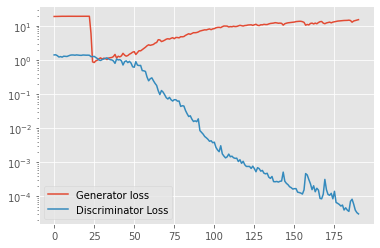

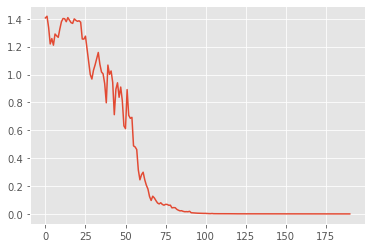

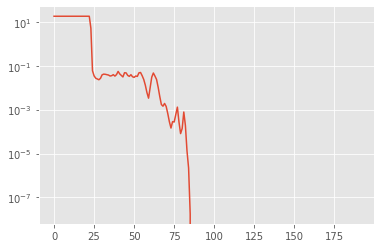

In [88]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.yscale('log')
plt.savefig('./outputs/generators/5_19/tanh_relu_loss.png')
plt.figure()
plt.plot(losses_d, label='Discriminator Loss')
plt.savefig('./outputs/generators/5_19/tanh_relu_loss_d.png')
plt.figure()
plt.plot(sats, label='Constraint satisfaction')
plt.yscale('log')
plt.savefig('./outputs/generators/5_19/tanh_relu_sat.png')